# Clustering Redshifts with SDSS and DELVE data

*Raul Teixeira*

# Goal

This notebook aims to provide a framework for estimating redshift distributions using the clustering redshift method, using the `treecorr` module.

# Summary

We use data from SDSS DR8 spectroscopic redshift catalog and DELVE DR2 crossmatched with SDSS DR17 data. 

# Imports and Setup

In [1]:
%matplotlib inline

from os.path import join
import time
import glob
import inspect
from importlib import reload
import warnings

import matplotlib as mpl
from matplotlib.colors import LogNorm

import numpy as np
import pylab as plt
import pandas as pd

import astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.coordinates.angle_utilities import angular_separation
from astropy.cosmology import LambdaCDM
import treecorr

mpl.rcParams['font.size'] = 12                  #changes the plot font size to 20
mpl.rcParams['font.family'] = 'serif'           #changes the font family to serif
mpl.rcParams['font.serif'] = ['cmr10']          #changes the font to Computer Modern Roman (dependent on the font family)
mpl.rcParams['mathtext.fontset'] = 'cm'         #changes the mathtype font to Computer Modern Roman
mpl.rcParams["axes.formatter.use_mathtext"] = True
mpl.rcParams['figure.figsize'] = [4,4]          #changes the figure dimensions to [width, height]
mpl.rcParams['figure.dpi'] = 120                #changes the figure dpi to [value]
plt.rc('axes', unicode_minus=False)             #makes negative signs plot correctly in CMR

# from sklearn.neighbors import KDTree

# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor 
# from sklearn import metrics

# from scipy.stats import gaussian_kde

from astr285.utils import get_sdssdir

import dl
from dl import queryClient as qc, authClient as ac

# Use pandas to read the data from a csv file
#filename = join(get_sdssdir(),'sdss_photoz.csv')
# If you get an OSError, you can define the path explicitly...
#filename = '/nbdata/astr28500/data/sdss/sdss_photoz.csv'
#data = pd.read_csv(filename)

# Load SDSS data

In [2]:
filename = join(get_sdssdir(),'SDSSspecgalsDR8.fits')
data = fits.open(filename)[1].data

ra, dec = data['ra'], data['dec']

In [3]:
delve_sdss = pd.read_csv('/home/jail/dlusers/raulteixeira/ASTR285s23/projects/raulteixeira/delve_dr2_sdss_dr17_matched.csv.gz')

In [4]:
data_c = data[(ra<275)&(ra>95)&(dec>-10)&(dec<33)]

In [5]:
delve_sdss_c = delve_sdss[(delve_sdss.ra<275)&\
                          (delve_sdss.ra>95)&\
                          (delve_sdss.dec>-10)&\
                          (delve_sdss.dec<33)]

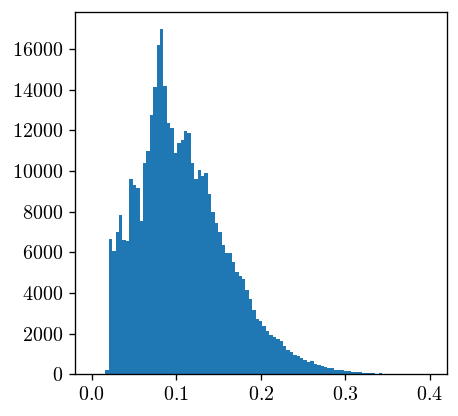

In [6]:
plt.hist(data_c['z'], bins=np.linspace(0,.4,100));

(array([ 8340., 13457., 22704., 28961., 32006., 49034., 44740., 37658.,
        36975., 33461., 27126., 21713., 18589., 14857., 11257., 10071.,
        10045.,  9129.,  8786.,  8830.,  9002., 10124., 12080., 13374.,
        14480., 14342., 13125., 12452., 11978.]),
 array([0.        , 0.0137931 , 0.02758621, 0.04137931, 0.05517241,
        0.06896552, 0.08275862, 0.09655172, 0.11034483, 0.12413793,
        0.13793103, 0.15172414, 0.16551724, 0.17931034, 0.19310345,
        0.20689655, 0.22068966, 0.23448276, 0.24827586, 0.26206897,
        0.27586207, 0.28965517, 0.30344828, 0.31724138, 0.33103448,
        0.34482759, 0.35862069, 0.37241379, 0.3862069 , 0.4       ]),
 <BarContainer object of 29 artists>)

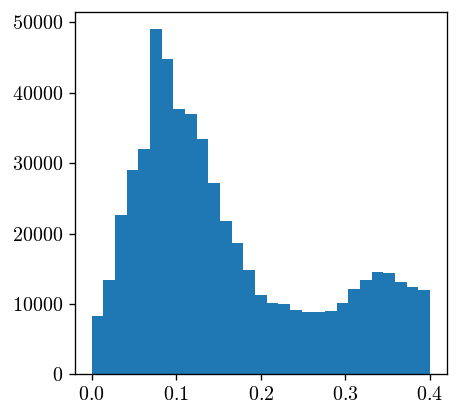

In [7]:
plt.hist(delve_sdss_c.z, bins=np.linspace(0,.4,30))

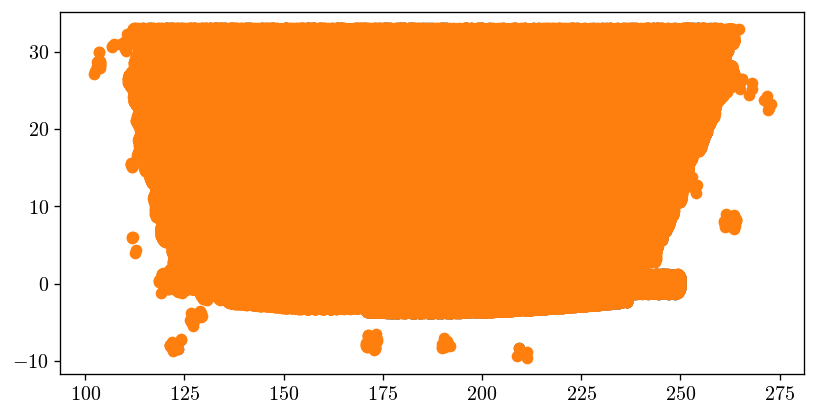

In [8]:
plt.figure(figsize=(8,4))
plt.scatter(data_c['ra'], data_c['dec'])
ids_c=np.random.randint(0, len(delve_sdss_c), size=int(1e2))
plt.scatter(delve_sdss_c['ra'], delve_sdss_c['dec'])

# Build redshift masks

In [9]:
z_r = data_c['z'] # redshifts of reference sample
z_u = delve_sdss_c['z'] # redshifts of unknown sample
z_bins = np.arange(0.02, .45, 0.02) # bin edges of z_bins

# building a dictionary with a mask for each redshift bin
def z_bin_masks(z, z_bins):
    return {'%.2f'%z_bins[i]+'-%.2f'%z_bins[i+1]:\
            (z_bins[i]<z)&(z<z_bins[i+1]) for i in range(len(z_bins)-1)}

z_bin_masks_all = z_bin_masks(data['z'], z_bins)
z_bin_masks_r = z_bin_masks(z_r, z_bins)
z_bin_masks_u = z_bin_masks(z_u, z_bins)

print(len(z_bin_masks_u), len(z_bin_masks_r))

print('z bins:', z_bins)

21 21
z bins: [0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44]


In [10]:
for key_r, key_u in zip(z_bin_masks_r, z_bin_masks_u):
    print('reference:'+key_r+':', np.sum(z_bin_masks_r[key_r]), 'objects')
    print('unknown:'+key_u+':', np.sum(z_bin_masks_u[key_u]), 'objects')

reference:0.02-0.04: 33716 objects
unknown:0.02-0.04: 31195 objects
reference:0.04-0.06: 41583 objects
unknown:0.04-0.06: 40035 objects
reference:0.06-0.08: 62432 objects
unknown:0.06-0.08: 60979 objects
reference:0.08-0.10: 67185 objects
unknown:0.08-0.10: 65163 objects
reference:0.10-0.12: 56856 objects
unknown:0.10-0.12: 55646 objects
reference:0.12-0.14: 48094 objects
unknown:0.12-0.14: 47547 objects
reference:0.14-0.16: 35315 objects
unknown:0.14-0.16: 35860 objects
reference:0.16-0.18: 26449 objects
unknown:0.16-0.18: 28022 objects
reference:0.18-0.20: 17077 objects
unknown:0.18-0.20: 19758 objects
reference:0.20-0.22: 10430 objects
unknown:0.20-0.22: 15018 objects
reference:0.22-0.24: 6607 objects
unknown:0.22-0.24: 14269 objects
reference:0.24-0.26: 3930 objects
unknown:0.24-0.26: 12858 objects
reference:0.26-0.28: 2261 objects
unknown:0.26-0.28: 12753 objects
reference:0.28-0.30: 1211 objects
unknown:0.28-0.30: 13989 objects
reference:0.30-0.32: 667 objects
unknown:0.30-0.32: 

# Random Sample Function

In [11]:
def random_sample(ra,dec,size=None):
    """Draw a uniform sample on a sphere covering the same (ra,dec) range
    as the input data.

    Parameters
    ----------
    ra, dec : Right Ascension and Declination in degrees
    size    : Size of the random sample returned

    Returns
    -------
    ra, dec : the random sample on the sphere covering the same region
    """
    ra = np.atleast_1d(ra)
    dec = np.atleast_1d(dec)
    if size is None: size = len(ra)

    zlim = np.sin(np.pi * np.asarray([dec.min(),dec.max()]) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    random_dec = (180. / np.pi) * np.arcsin(z)
    random_ra = ra.min() + (ra.max() - ra.min()) * np.random.random(size)
    randoms = np.rec.fromarrays([random_ra,random_dec],names=['ra','dec'])
    return randoms

# TreeCorr Configuration and Randomized Coordinates

In [12]:
config = { 'ra_col' : 'ALPHA2000',
               'dec_col' : 'DELTA2000',
               'g1_col' : 'E1',
               'g2_col' : 'E2',
               'ra_units' : 'deg',
               'dec_units' : 'deg' }

Njk = 100 # number of jackknife regions

n_ref = len(data_c)
n_targ = len(delve_sdss_c)

rand_ref_coords = random_sample(data_c.ra, data_c.dec, size=n_ref)
ref_rand_ra, ref_rand_dec = rand_ref_coords['ra'], rand_ref_coords['dec']

rand_targ_coords = random_sample(delve_sdss_c.ra, delve_sdss_c.dec, size=n_targ)
targ_rand_ra, targ_rand_dec = rand_targ_coords['ra'], rand_targ_coords['dec']


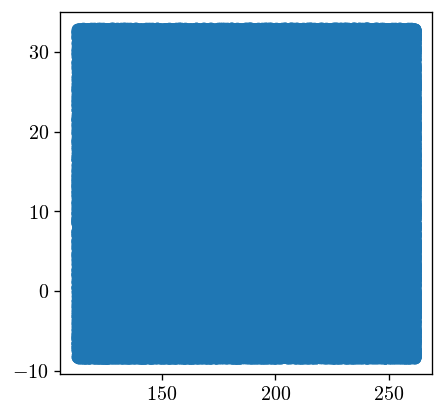

In [13]:
# check sky coverage of randomized coordinates
plt.scatter(ref_rand_ra, ref_rand_dec)

# Weight function to be used in building the N(z)

In [14]:
def weight_func(theta_min, theta_max, gamma=1, nbins=20):
    """
    returns a weight function normalized to unit when integrated
    """
    w_init = np.linspace(theta_min, theta_max, nbins)**(-gamma)
    w_init/=np.sum(w_init)
    return w_init

0 6.3183654544261305 63.1836545442613


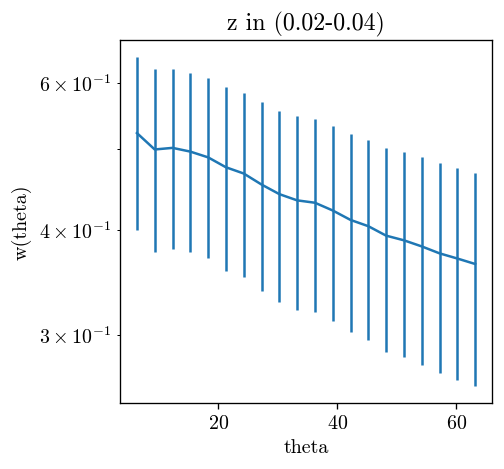

1 4.313222005889853 43.132220058898525


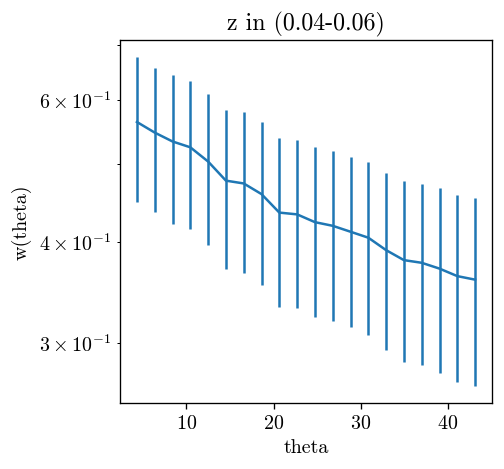

2 3.311462020768468 33.11462020768468


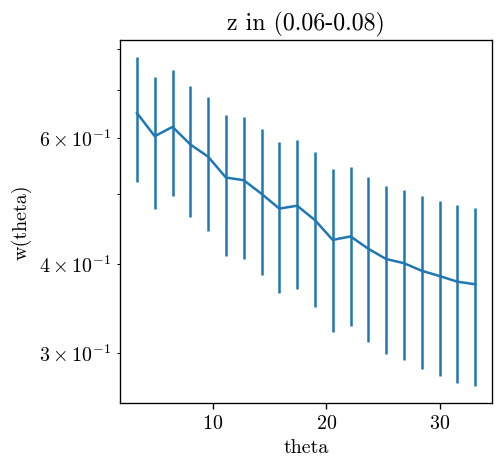

3 2.711062894295796 27.110628942957963


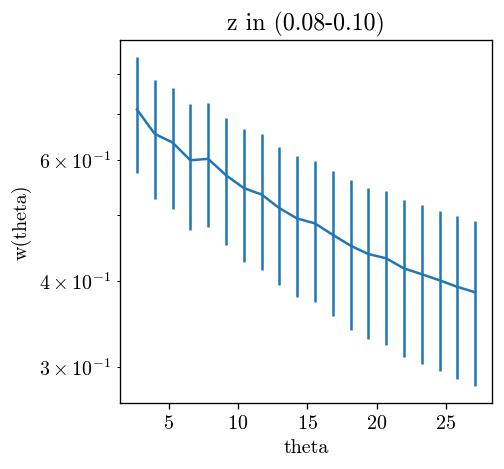

4 2.311350136616779 23.11350136616779


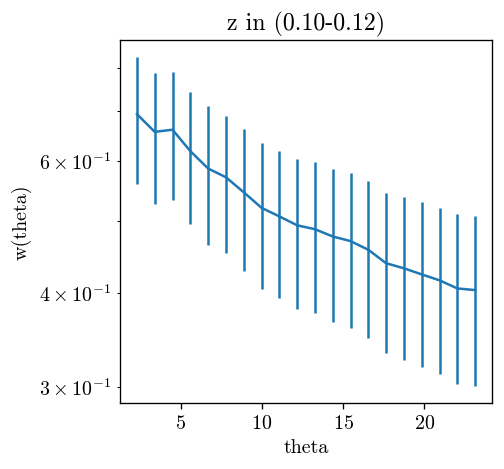

5 2.0263201509059927 20.263201509059925


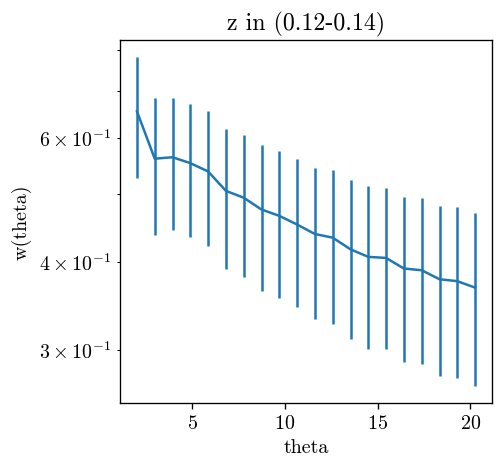

6 1.8129709285014628 18.129709285014627


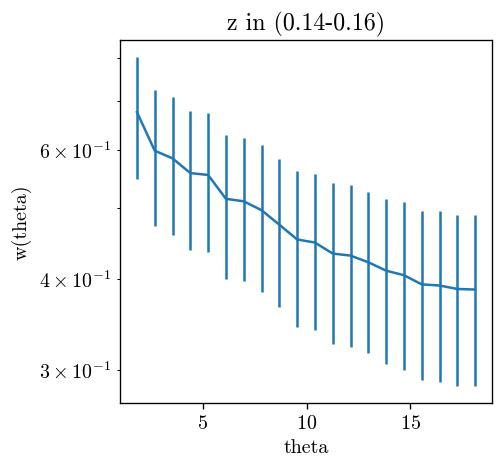

7 1.647412281099141 16.47412281099141


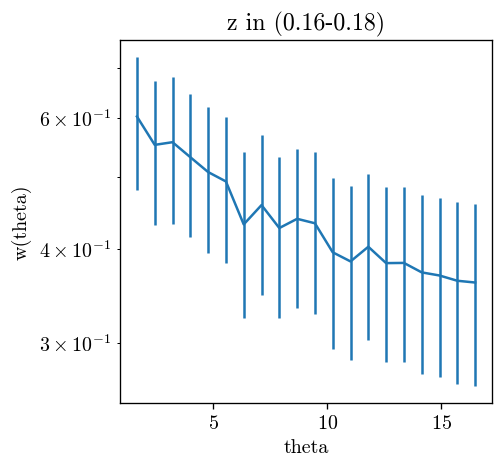

8 1.5153099340176768 15.153099340176768


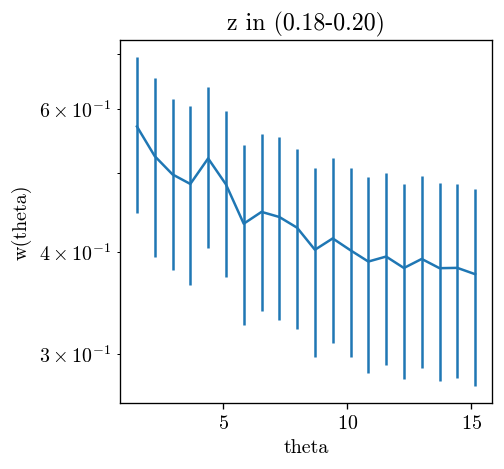

9 1.407541932535139 14.07541932535139


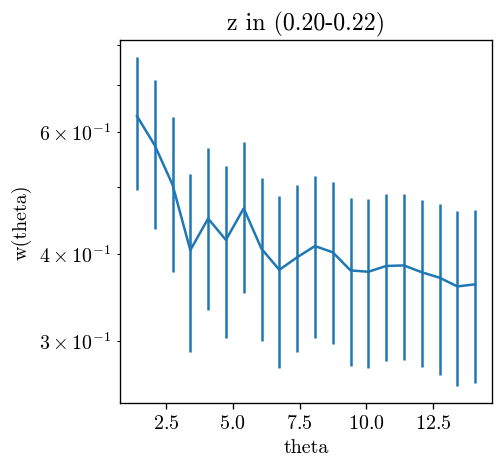

10 1.3180268453014377 13.180268453014376


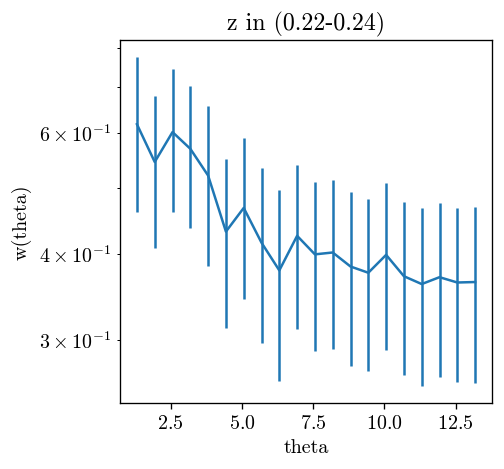

11 1.2425543355966833 12.425543355966832


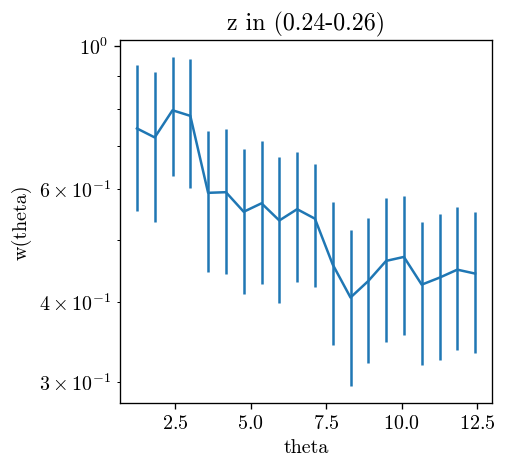

12 1.1781169164823277 11.781169164823277


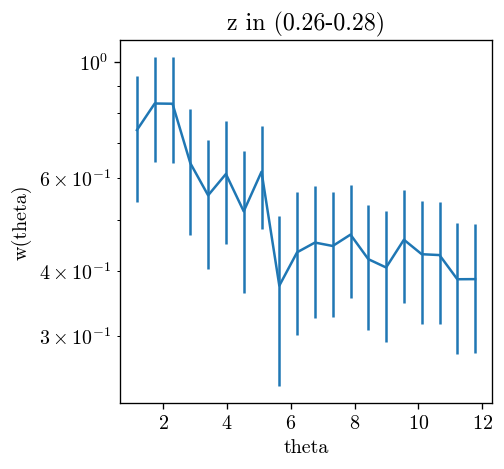

13 1.122509004001143 11.22509004001143
The following patch numbers have no objects: {5}
This may be a problem depending on your use case.


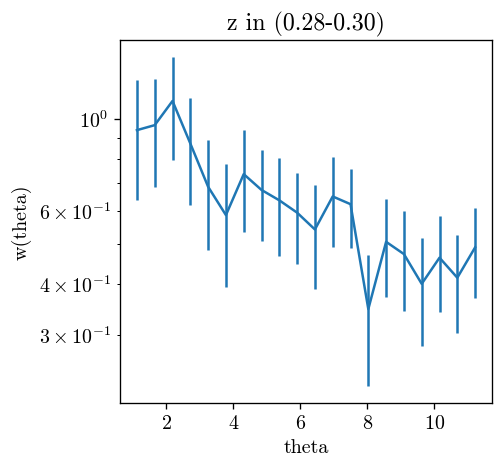

14 1.0740763255059889 10.740763255059889
The following patch numbers have no objects: {98}
This may be a problem depending on your use case.


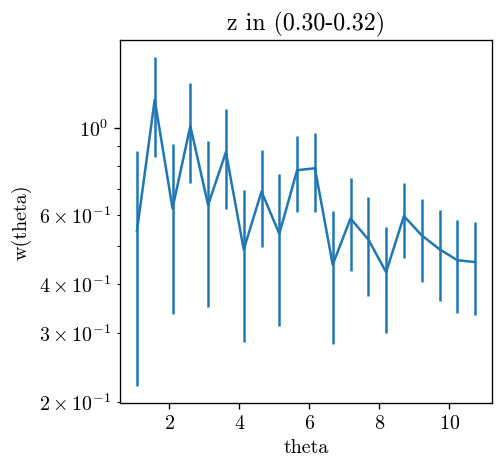

15 1.0315537721610157 10.315537721610157
The following patch numbers have no objects: {1, 71, 44, 83, 84, 87, 55, 88, 27}
This may be a problem depending on your use case.


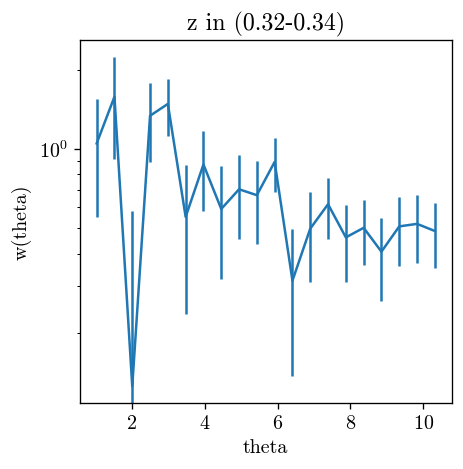

16 0.9939573006412022 9.939573006412022
The following patch numbers have no objects: {6, 9, 19, 21, 25, 26, 27, 33, 34, 35, 39, 49, 52, 57, 61, 71, 80, 81, 83, 84, 88, 89, 91, 93, 97, 98}
This may be a problem depending on your use case.


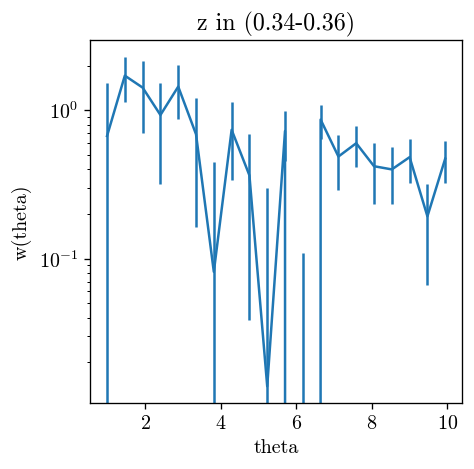

17 0.9605099711517042 9.605099711517042
The following patch numbers have no objects: {1, 2, 7, 8, 10, 12, 15, 18, 19, 21, 22, 23, 25, 30, 32, 33, 36, 38, 41, 43, 45, 46, 47, 48, 50, 51, 52, 54, 55, 56, 57, 61, 62, 63, 67, 70, 72, 75, 77, 79, 81, 82, 83, 84, 85, 86, 90, 92, 96, 98, 99}
This may be a problem depending on your use case.


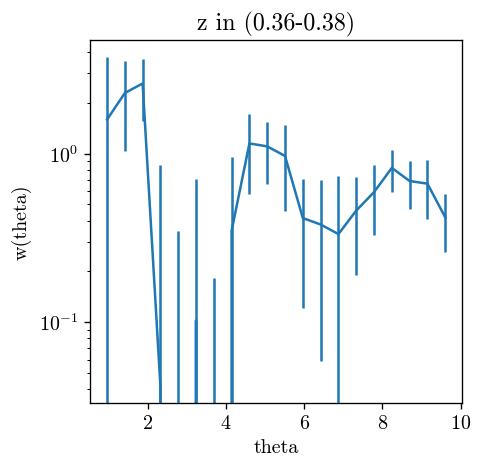

18 0.9305901740415455 9.305901740415456
The following patch numbers have no objects: {2, 3, 4, 6, 8, 11, 12, 13, 16, 19, 20, 21, 23, 24, 25, 27, 28, 29, 32, 33, 34, 35, 37, 38, 40, 43, 44, 45, 46, 48, 49, 51, 53, 54, 55, 57, 58, 59, 60, 61, 62, 64, 66, 67, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 99}
This may be a problem depending on your use case.


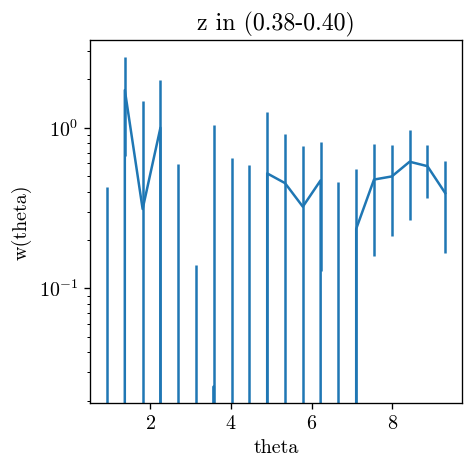

19 0.9036946488017192 9.036946488017193
The following patch numbers have no objects: {0, 1, 2, 3, 4, 5, 7, 8, 10, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 26, 27, 28, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 47, 48, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 89, 90, 91, 94, 95, 96, 97, 98, 99}
This may be a problem depending on your use case.


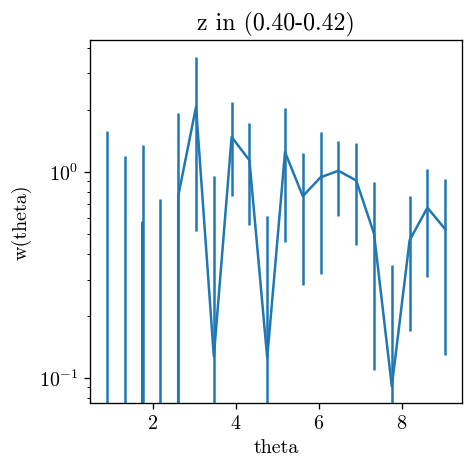

20 0.8794115887699322 8.794115887699322
The following patch numbers have no objects: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 34, 35, 36, 38, 40, 41, 42, 43, 44, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99}
This may be a problem depending on your use case.


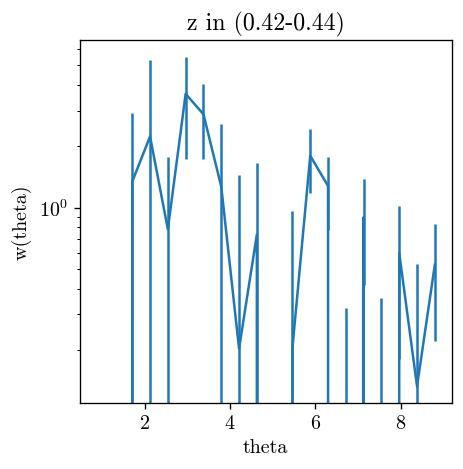

CPU times: user 1h 14min 34s, sys: 1min 18s, total: 1h 15min 52s
Wall time: 4min 44s


In [15]:
%%time
grid = []
errs = []
weight_grid = []
Cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7) # cosmology used to make rough angular diameter distance measurements
for i, (key_r, key_u) in enumerate(zip(z_bin_masks_r, z_bin_masks_u)):
    arcsec_p_kpc = Cosmo.arcsec_per_kpc_proper(z=z_bins[i+1])
    min_sep = arcsec_p_kpc*300/60*u.kpc/u.arcsec #in arcmin
    max_sep = min_sep*10 #in arcmin
    print(i, min_sep, max_sep)
    
    #catalogs
    ran_ALL = treecorr.Catalog(ra=delve_sdss_c.ra, dec=delve_sdss_c.dec, ra_units='deg', dec_units='deg', npatch=Njk)
    
    cat_targ_rand = treecorr.Catalog(ra=targ_rand_ra, dec=targ_rand_dec, ra_units='deg', dec_units='deg', patch_centers=ran_ALL.patch_centers)
    cat_ref_rand = treecorr.Catalog(ra=ref_rand_ra, dec=ref_rand_dec, ra_units='deg', dec_units='deg', patch_centers=ran_ALL.patch_centers)

    cat_ref = treecorr.Catalog(ra=data_c.ra[z_bin_masks_r[key_r]], dec=data_c.dec[z_bin_masks_r[key_r]],\
                               ra_units='deg', dec_units='deg', patch_centers=ran_ALL.patch_centers)
    cat_targ = treecorr.Catalog(ra=delve_sdss_c.ra, dec=delve_sdss_c.dec,\
                                ra_units='deg', dec_units='deg', patch_centers=ran_ALL.patch_centers)
    
    dd = treecorr.NNCorrelation(config, nbins=20, min_sep=min_sep, max_sep=max_sep,\
                                sep_units='arcmin', var_method='jackknife', bin_slop=0.01)
    rr = treecorr.NNCorrelation(config, nbins=20, min_sep=min_sep, max_sep=max_sep,\
                                sep_units='arcmin', var_method='jackknife', bin_slop=0.01)
    dr = treecorr.NNCorrelation(config, nbins=20, min_sep=min_sep, max_sep=max_sep,\
                                sep_units='arcmin', var_method='jackknife', bin_slop=0.01)
    rd = treecorr.NNCorrelation(config, nbins=20, min_sep=min_sep, max_sep=max_sep,\
                                sep_units='arcmin', var_method='jackknife', bin_slop=0.01) 

    dd.process(cat_targ, cat_ref)
    rr.process(cat_targ_rand, cat_ref_rand)
    dr.process(cat_targ, cat_ref_rand)
    rd.process(cat_targ_rand, cat_ref)
    
    # 2-pt correlation function
    xi, varxi = dd.calculateXi(rr=rr,dr=dr,rd=rd)  # Or get correlation function directly.
    weights = weight_func(min_sep, max_sep, gamma=1, nbins=20)
    var_wbar = np.einsum("i,ij,j->", np.array(weights), dd.cov, np.array(weights))
    weight_grid.append(weights)
    errs.append(np.sqrt(var_wbar))
    grid.append(xi)
    
    # plots
    plt.figure()
    plt.yscale('log')
    plt.ylabel('w(theta)')
    plt.xlabel('theta')
    plt.title(f'z in ({key_r})')
    plt.errorbar(np.linspace(min_sep, max_sep, 20), xi, np.sqrt(varxi))
    plt.show()

In [16]:
w_mean = np.sum(np.array(weight_grid)*np.array(grid), axis=1)
p_z = w_mean/sum(w_mean) * len(delve_sdss_c)
Nz_errs = np.array(errs)*len(delve_sdss_c)

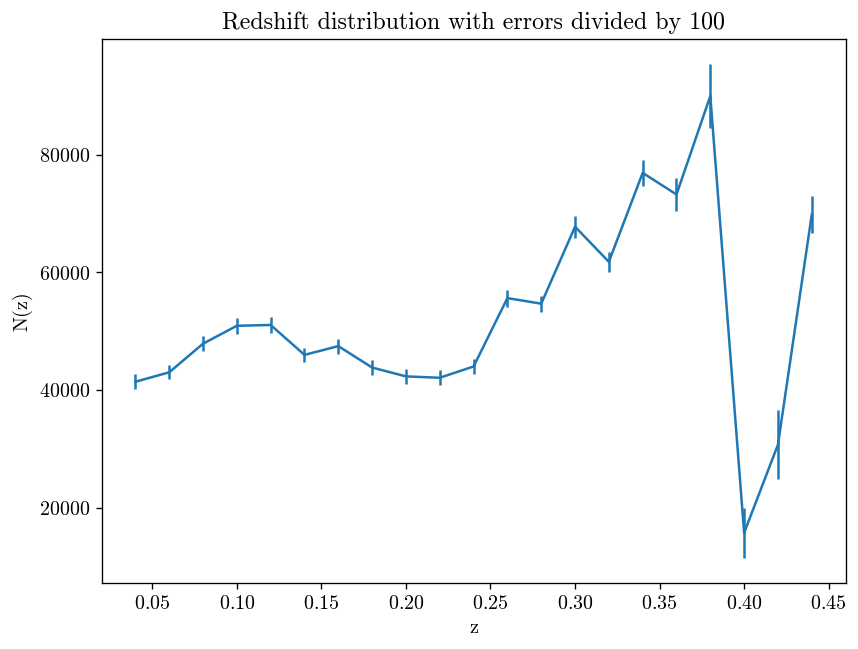

In [17]:
plt.figure(figsize=(8,6))
plt.title('Redshift distribution with errors divided by 100')
plt.errorbar(z_bins[1:], p_z, Nz_errs/1e2)
plt.xlabel('z')
plt.ylabel('N(z)')
plt.show()

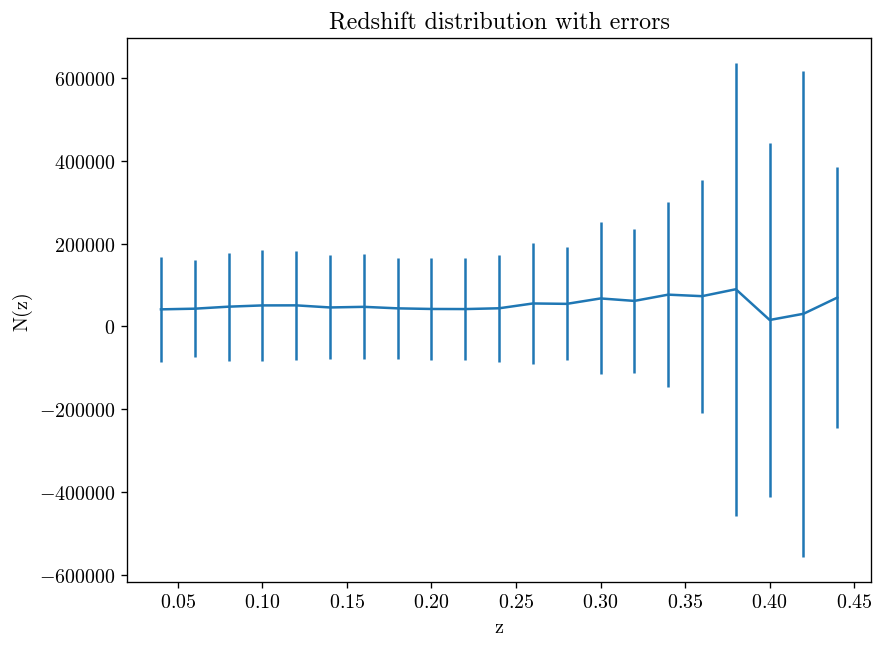

In [18]:
plt.figure(figsize=(8,6))
plt.title('Redshift distribution with errors')
plt.errorbar(z_bins[1:], p_z, Nz_errs)
plt.xlabel('z')
plt.ylabel('N(z)')
plt.show()

We can see the distribution is highly uncertain, due primarily to how small the dataset is, which is highlighted in the higher redshift bins.

# References

TreeCorr module, by Mike Jarvis https://rmjarvis.github.io/TreeCorr/_build/html/index.html

Ménard et al., “Clustering-Based Redshift Estimation: Method and Application to Data.” arXiv, July 30, 2014. http://arxiv.org/abs/1303.4722.